In [1]:
!pip install Pillow==7.1.2
# import the new one
import PIL
print(PIL.PILLOW_VERSION)
# this should print 5.3.0. If it doesn't, then restart your runtime:
# Menu > Runtime > Restart Runtime
!pip install image
# !pip3 install https://download.pytorch.org/whl/cu80/torch-0.4.0-cp36-cp36m-win_amd64.whl
!pip3 install torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: PILLOW_VERSION is deprecated and will be removed in a future release. Use __version__ instead.
  after removing the cwd from sys.path.


7.1.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.9 MB 41.0 MB/s 
  Created wheel for image: filename=image-1.5.33-py2.py3-none-any.whl size=19496 sha256=c9bf57f115ed8eda00f3019d8e5f63e837257a42af9754682c9eb73216f17c81
  Stored in directory: /root/.cache/pip/wheels/56/88/e6/897194cfe8c08a8b9afd881d3bf53d102e13fa39607d721383
Successfully built image
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import PIL
print(PIL.PILLOW_VERSION)

7.1.2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: PILLOW_VERSION is deprecated and will be removed in a future release. Use __version__ instead.
  


In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import glob
import torch
import time
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision
from collections import OrderedDict
from torch.autograd import Variable
from PIL import Image
import PIL
from torch.optim import lr_scheduler
import copy
import json
import os
from os.path import exists
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


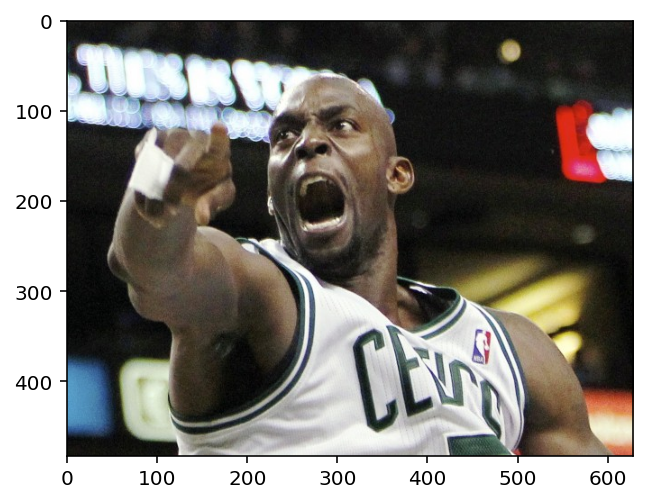

In [5]:
image = cv2.imread('/content/drive/MyDrive/bamboo/images/anger/athletes/0.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [6]:
data_dir = '/content/drive/MyDrive/image'
train_dir = data_dir + '/Train'
valid_dir = data_dir + '/Valid'
nThreads = 4
batch_size = 16
use_gpu = torch.cuda.is_available()

In [7]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [8]:
data_transforms = {
    'Train': transforms.Compose([
        #transforms.RandomRotation(24),
        transforms.RandomResizedCrop(224),
        #transforms.ColorJitter(contrast=0),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Valid': transforms.Compose([
        transforms.Resize(177),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load the datasets with ImageFolder

data_dir = '/content/drive/MyDrive/image'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['Train', 'Valid']}

# Using the image datasets and the transforms, define the dataloaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=6,
                                             shuffle=True, num_workers=2)
              for x in ['Train', 'Valid']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['Train', 'Valid']}


class_names= image_datasets['Train'].classes

In [10]:
data_transforms

{'Train': Compose(
     RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
     RandomHorizontalFlip(p=0.5)
     ToTensor()
     Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
 ), 'Valid': Compose(
     Resize(size=177, interpolation=bilinear, max_size=None, antialias=None)
     CenterCrop(size=(224, 224))
     ToTensor()
     Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
 )}

In [11]:
image_datasets

{'Train': Dataset ImageFolder
     Number of datapoints: 2771
     Root location: /content/drive/MyDrive/image/Train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ), 'Valid': Dataset ImageFolder
     Number of datapoints: 274
     Root location: /content/drive/MyDrive/image/Valid
     StandardTransform
 Transform: Compose(
                Resize(size=177, interpolation=bilinear, max_size=None, antialias=None)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            )}

In [12]:
dataset_sizes

{'Train': 2771, 'Valid': 274}

In [13]:
class_names

['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']

In [14]:
dataloaders['Train']

In [15]:
inputs, classes = next(iter(dataloaders['Train']))
classes
inputs

tensor([[[[-0.6623, -0.7993, -0.9192,  ..., -1.4329, -1.3987, -1.3815],
          [-0.6452, -0.7993, -0.9192,  ..., -1.4329, -1.3987, -1.3987],
          [-0.5424, -0.6965, -0.8335,  ..., -1.4158, -1.3815, -1.3644],
          ...,
          [-1.2445, -1.1589, -0.8164,  ..., -0.3198, -0.4911, -0.6281],
          [-1.0562, -1.0219, -0.8335,  ..., -0.2856, -0.4568, -0.5938],
          [-0.9020, -0.8678, -0.7822,  ..., -0.2856, -0.4568, -0.5938]],

         [[-0.5301, -0.7227, -0.8627,  ..., -1.3354, -1.3004, -1.3004],
          [-0.4426, -0.6352, -0.7927,  ..., -1.3354, -1.3004, -1.3004],
          [-0.2325, -0.4076, -0.5826,  ..., -1.3179, -1.2829, -1.2829],
          ...,
          [-1.2479, -1.1604, -0.8277,  ..., -0.2500, -0.4426, -0.5476],
          [-1.0728, -1.0378, -0.8627,  ..., -0.2325, -0.3901, -0.5126],
          [-0.9328, -0.8978, -0.8102,  ..., -0.2325, -0.3901, -0.5126]],

         [[-1.1421, -1.2641, -1.3513,  ..., -1.5430, -1.4907, -1.4210],
          [-1.0201, -1.1770, -

In [16]:
for x in classes:
  print(x)

tensor(3)
tensor(0)
tensor(4)
tensor(5)
tensor(4)
tensor(5)


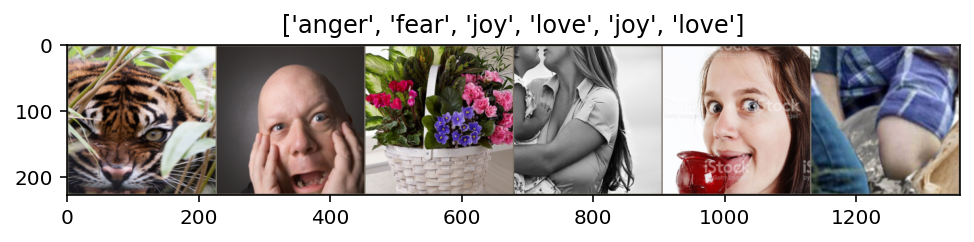

In [9]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['Train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
plt.figure(figsize=(8, 8))
imshow(out, title=[class_names[x] for x in classes])

In [10]:
# Build and train your network

# 1. Load resnet-152 pre-trained network
model = models.resnet152(pretrained=True)
# Freeze parameters so we don't backprop through them

for param in model.parameters():
    param.requires_grad = False

print(model)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
# 2. Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout

# our input_size matches the in_features of pretrained model


from collections import OrderedDict


# creating the classifier ordered dictionary first

classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2048, 1024)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(1024, 3)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))



# replacing the pretrained model classifier with our classifier
model.fc = classifier
model.fc

Sequential(
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=1024, out_features=3, bias=True)
  (output): LogSoftmax(dim=1)
)

In [12]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(1, num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['Train', 'Valid']:
            if phase == 'Train':
                optimizer.zero_grad()
                optimizer.step()
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                # inputs, labels = inputs.to(device), labels.to(device)
                inputs, labels = inputs.cuda(), labels.cuda()

                # zero the parameter gradients
                # optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'Train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'Train':
                        loss.backward()
                        # optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'Valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best valid accuracy: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [21]:
for inputs, labels in dataloaders['Train']:
  if torch.cuda.is_available():
      inputs = inputs.cuda()
      labels = labels.cuda()
  # inputs, labels = inputs.to(device), labels.to(device)
  print(inputs)
  print(labels)
  break
model(inputs)

RuntimeError: ignored

In [18]:
labels

tensor([2, 0, 3, 5, 4, 5])

In [14]:
inputs, labels =  inputs.to(device), labels.to(device)
# inputs = Variable(inputs.float().cuda())
model(inputs)

RuntimeError: ignored

In [13]:
#Train a model with a pre-trained network
num_epochs = 5
if use_gpu:
    print ("Using GPU: "+ str(use_gpu))
    model = model.cuda()

# NLLLoss because our output is LogSoftmax
criterion = nn.NLLLoss()

 #Adam optimizer with a learning rate
optimizer = optim.Adam(model.fc.parameters(), lr=0.0001)
#optimizer = optim.SGD(model.fc.parameters(), lr = .1, momentum=0.9)
# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=10)

Using GPU: True
Epoch 1/10
----------


RuntimeError: ignored

In [23]:
# Do validation on the test set
def test(model, dataloaders, device):
  model.eval()
  accuracy = 0
  
  model.to(device)
    
  for images, labels in dataloaders['Valid']:
    images = Variable(images)
    labels = Variable(labels)
    images, labels = images.to(device), labels.to(device)
      
    output = model.forward(images)
    ps = torch.exp(output)
    equality = (labels.data == ps.max(1)[1])
    accuracy += equality.type_as(torch.FloatTensor()).mean()
      
    print("Testing Accuracy: {:.3f}".format(accuracy/len(dataloaders['Valid'])))

In [24]:
test(model, dataloaders, device)

RuntimeError: ignored

In [ ]:
torch.cuda.is_available()

In [ ]:
if torch.cuda.is_available:
  print('GPU available')
else:
  print('Please set GPU via Edit -> Notebook Settings.')

In [ ]:
print("Torch version:{}".format(torch.__version__))
print("cuda version: {}".format(torch.version.cuda))
print("cudnn version:{}".format(torch.backends.cudnn.version()))

In [ ]:
!nvcc --version

In [ ]:
!cat /usr/include/x86_64-linux-gnu/cudnn_v*.h | grep CUDNN_MAJOR -A 2

In [ ]:
cpu_tensor = torch.zeros(2,3)
print(cpu_tensor)

In [ ]:
# https://pytorch.org/docs/stable/tensor_attributes.html#torch.torch.device
# 어느 장치(cpu 혹은 gpu)에 텐서를 올릴지 지정합니다.
# 아래는 torch.device라는 함수를 사용해 gpu로 장치를 지정합니다. 
device = torch.device('cuda')

# https://pytorch.org/docs/stable/cuda.html?highlight=available#torch.cuda.is_available
# gpu가 사용 가능한지 확인해줍니다.
if torch.cuda.is_available():
  
  # https://pytorch.org/docs/stable/tensors.html?highlight=#torch.Tensor.to
  # cpu에 있었던 텐서를 to 함수를 이용해 지정해놓은 장치(여기서는 gpu)로 올려줍니다.
  gpu_tensor = cpu_tensor.to(device)
  print(gpu_tensor)